# EJERCICOS USANDO MODELO DE MERCADO

Veamos si hay una relación lineal entre las $\beta$ y los retornos de los activo como dice el modelo de mercado. Según el modelo de mercado:

$$\Large  R_{i,t} - R_f = \alpha_i + \beta_i (R_{Mt} - R_f) + \epsilon_{i,t} $$

donde:

- $ R_{it} $: Rendimiento del activo individual
- $ \alpha_i $: Alpha del activo
- $ \beta_i $: Beta del activo
- $ R_{mt} $: Rendimiento del indice de mercado
- $ \epsilon_i $: Término de error

Por lo tanto, los **activos con mayor $\boldsymbol \beta$ deben tener mayor rentabilidad**.

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import cvxpy as cp
import plotly.graph_objects as go
from tqdm.auto import tqdm
import statsmodels.api as sm
import warnings
from datetime import datetime, timedelta

# print(plt.style.available) #list of available styles
#plt.style.use('ggplot')
# Configura el estilo de Seaborn para que los gráficos se vean más atractivos
sns.set(style="whitegrid")

plt.rcParams['figure.figsize'] = [16, 9]
plt.rcParams['figure.dpi'] = 100
warnings.simplefilter(action='ignore', category=FutureWarning)

In [59]:
def calc_regresion(r_ind, r):
    res = []
    summary = []
    
    for activo in r.columns:
        X = r_ind
        y = r[activo]
        X_sm = sm.add_constant(X)
        
        modelo = sm.OLS(y, X_sm).fit()
        
        resultado = {
        'activo': activo,
        'alpha': modelo.params[0],
        'beta': modelo.params[1],
        'p_value_alpha': modelo.pvalues[0],
        'p_value_beta': modelo.pvalues[1],
        't_value_alpha': modelo.tvalues[0],
        't_value_beta': modelo.tvalues[1],
        'rsquared': modelo.rsquared,
        'fvalue': modelo.fvalue,
        'conf_int_alpha_low': modelo.conf_int()[0][0],
        'conf_int_alpha_high': modelo.conf_int()[0][1],
        'conf_int_beta_low': modelo.conf_int()[1][0],
        'conf_int_beta_high': modelo.conf_int()[1][1],
        'aic': modelo.aic,
        'bic': modelo.bic
        }
        
        res.append(resultado)
        summary.append(modelo.summary())
        
    df_resul = pd.DataFrame(res)
    df_resul = df_resul.set_index('activo')
    
    df_summ = pd.DataFrame(summary)
    df_summ.index = r.columns
    
    return df_resul, df_summ
        

In [60]:
# Nos bajamoslos precios diarios del SP500 y calculamos los precios semanales, mensuales, trimestrales y anuales

start_date = '1995-01-01'
precios_indice = yf.download("SPY", start=start_date)[["Adj Close"]] # Precios ajustados al cierre
ret_indice_sp500 = np.log(precios_indice).diff().dropna()

[*********************100%%**********************]  1 of 1 completed


In [61]:
filepath = 'https://raw.githubusercontent.com/alfonso-santos/microcredencial-carteras-python-2023/main/Tema_5_APT/data/sp500_tickers.csv'
tickers_sp500 = list(pd.read_csv(filepath))

precios = yf.download(tickers_sp500, start=start_date)['Adj Close']

[                       0%%                      ]

[*********************100%%**********************]  503 of 503 completed

3 Failed downloads:
['BRK.B', 'CDAY']: Exception('%ticker%: No timezone found, symbol may be delisted')
['BF.B']: Exception('%ticker%: No price data found, symbol may be delisted (1d 1995-01-01 -> 2024-04-08)')


In [62]:
precios_activos_sp500 = precios.copy()
precios_activos_sp500.dropna(axis=1, inplace=True)
ret_activos_sp500 = np.log(precios_activos_sp500).diff().dropna()

Calculad:

1- las betas de los activos

2- sus retornos medios

3- Haced la regresión entre ellos

4- Dibujad la gráfica

In [63]:
df_all_res, df_all_summary = calc_regresion(ret_indice_sp500, ret_activos_sp500)

In [7]:
df_all_res.head(2)

,alpha,beta,p_value_alpha,p_value_beta,t_value_alpha,t_value_beta,rsquared,fvalue,conf_int_alpha_low,conf_int_alpha_high,conf_int_beta_low,conf_int_beta_high,aic,bic
activo,,,,,,,,,,,,,,
AAPL,0.000424,1.105479,0.127613,0.0,1.523753,48.020674,0.238493,2305.985163,-0.000121,1.060351,0.000969,1.150607,-34120.666009,-34106.857020
ABT,0.000190,0.665467,0.223380,0.0,1.217693,51.430392,0.264295,2645.085255,-0.000116,0.640102,0.000497,0.690831,-42607.255221,-42593.446232


In [8]:
# Obtener los valores de los retornos promedio del S&P 500 y los valores de beta
ret_sp500_promedio = ret_activos_sp500.mean()
betas = df_all_res['beta']


In [64]:
#Regresión lineal entre los retornos medios y los valores de beta
betas_con_constante = sm.add_constant(betas)

# Crear el modelo OLS
modelo = sm.OLS(ret_sp500_promedio, betas_con_constante)

# Ajustar el modelo
resultado = modelo.fit()

# Mostrar un resumen del modelo
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                 -0.003
Method:                 Least Squares   F-statistic:                   0.08422
Date:                Mon, 08 Apr 2024   Prob (F-statistic):              0.772
Time:                        10:27:41   Log-Likelihood:                 2209.3
No. Observations:                 302   AIC:                            -4415.
Df Residuals:                     300   BIC:                            -4407.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004   3.37e-05     13.093      0.0

Hagamos el gráfico de los valores y la regersión lienal

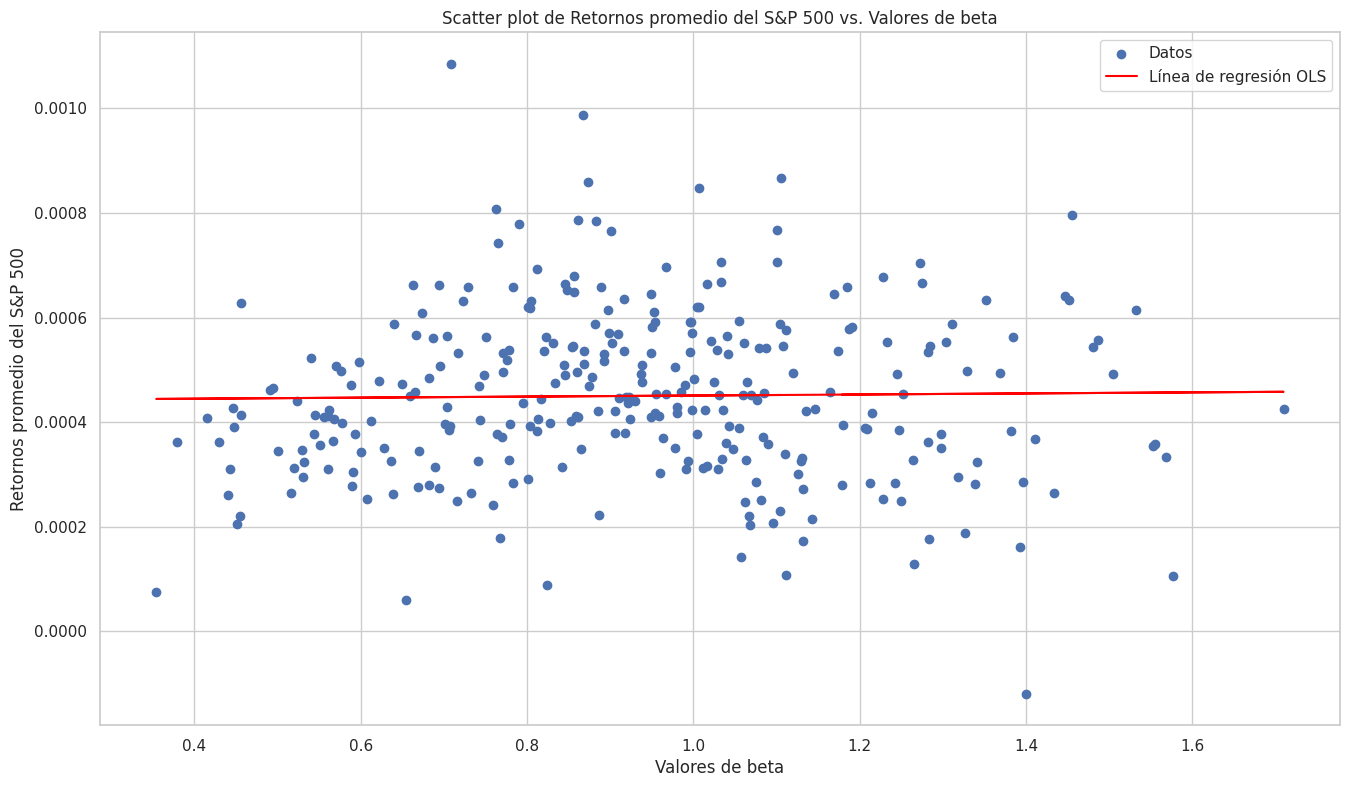

In [10]:
# Obtener los valores ajustados (predicciones del modelo)
valores_ajustados = resultado.predict(betas_con_constante)

# Crear el gráfico de dispersión
plt.scatter(betas, ret_sp500_promedio, label='Datos')

# Dibujar la línea de regresión
plt.plot(betas, valores_ajustados, color='red', label='Línea de regresión OLS')

# Añadir etiquetas y título
plt.ylabel('Retornos promedio del S&P 500')
plt.xlabel('Valores de beta')
plt.title('Scatter plot de Retornos promedio del S&P 500 vs. Valores de beta')
plt.legend()

# Mostrar el gráfico
plt.show()

**¿CUÁL ES LA CONCLUSIÓN?**

## Uso de $\beta$ para gestionar carteras


Vamos a analizar la evolución de los precios de un índice para determinar si el modelo de mercado se comporta de manera consistente durante periodos de tendencias alcistas y bajistas, evaluando así su eficacia bajo distintas condiciones del mercado.

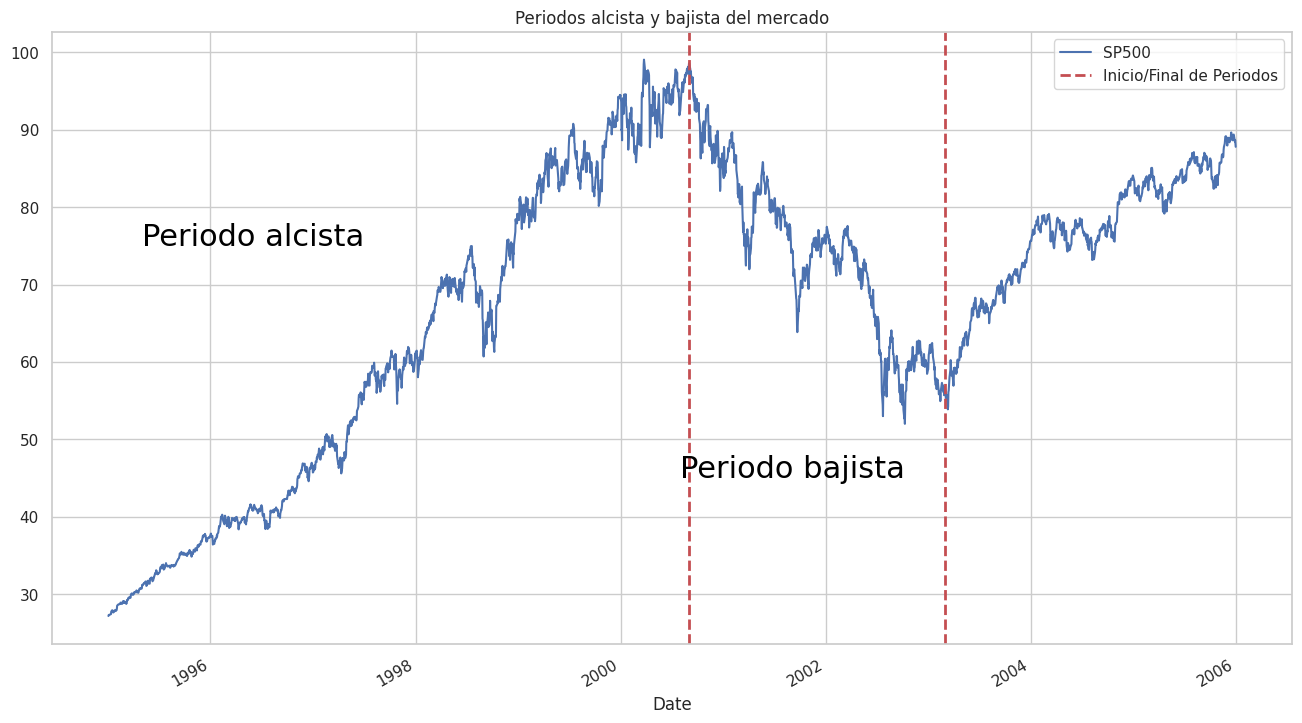

In [11]:
precios_indice.loc['1995':'2005'].plot(label='SP500')

# Añadir líneas verticales rojas punteadas en las fechas especificadas
plt.axvline('2000-9-01', color='r', linestyle='--', linewidth=2, label='Inicio/Final de Periodos')
plt.axvline('2003-03-01', color='r', linestyle='--', linewidth=2)

# Añadir texto para el periodo alcista
plt.text('1995-05', 75, 'Periodo alcista', fontsize=22, color='black')

# Añadir texto para el periodo alcista
plt.text('2000-8', 45, 'Periodo bajista', fontsize=22, color='black')

# Añadir título al gráfico
plt.title('Periodos alcista y bajista del mercado')

# Opcional: Añadir leyenda para explicar las líneas rojas
# Añadir manualmente la leyenda con las etiquetas deseadas
plt.legend(['SP500', 'Inicio/Final de Periodos'])

# Mostrar el gráfico
plt.show()


Dividimos los precios y retornos para el periodo bajista y el alcista

In [65]:
precios_antes = precios_activos_sp500.loc['1995':'2000-9-01']

precios_bajada = precios_activos_sp500.loc['2000-9-02':'2002']

precios_ant_baj = precios_activos_sp500.loc['1995':'2002']

In [66]:
retornos_ant = np.log(precios_antes).diff().dropna()
retornos_baj = np.log(precios_bajada).diff().dropna()
retornos_ant_baj = np.log(precios_ant_baj).diff().dropna()


In [67]:
precios_indice_antes = precios_indice.loc['1995':'2000-9-01']

precios_indice_bajada = precios_indice.loc['2000-9-02':'2002']

precios_indice_ant_baj = precios_indice.loc['1995':'2002']

In [68]:
retornos_indice_ant = np.log(precios_indice_antes).diff().dropna()
retornos_indice_baj = np.log(precios_indice_bajada).diff().dropna()
retornos_indice_ant_baj = np.log(precios_indice_ant_baj).diff().dropna()


#### Periodo Alcista

Calculemos las $\beta$ en el periodo alcista:

In [69]:
df_ant_resul, df_ant_summ = calc_regresion(retornos_indice_ant, retornos_ant)

In [70]:
# Obtener los valores de los retornos promedio del S&P 500 y los valores de beta
retornos_sp500_ant_promedio = retornos_ant.mean()
betas_ant = df_ant_resul['beta']


In [71]:
betas_ant_con_constante = sm.add_constant(betas_ant)

# Crear el modelo OLS
modelo = sm.OLS(retornos_sp500_ant_promedio, betas_ant_con_constante)

# Ajustar el modelo
resultado = modelo.fit()

# Mostrar un resumen del modelo
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.361
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     169.5
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           5.01e-31
Time:                        10:30:46   Log-Likelihood:                 1881.2
No. Observations:                 302   AIC:                            -3758.
Df Residuals:                     300   BIC:                            -3751.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.171e-05   6.38e-05     -0.184      0.8

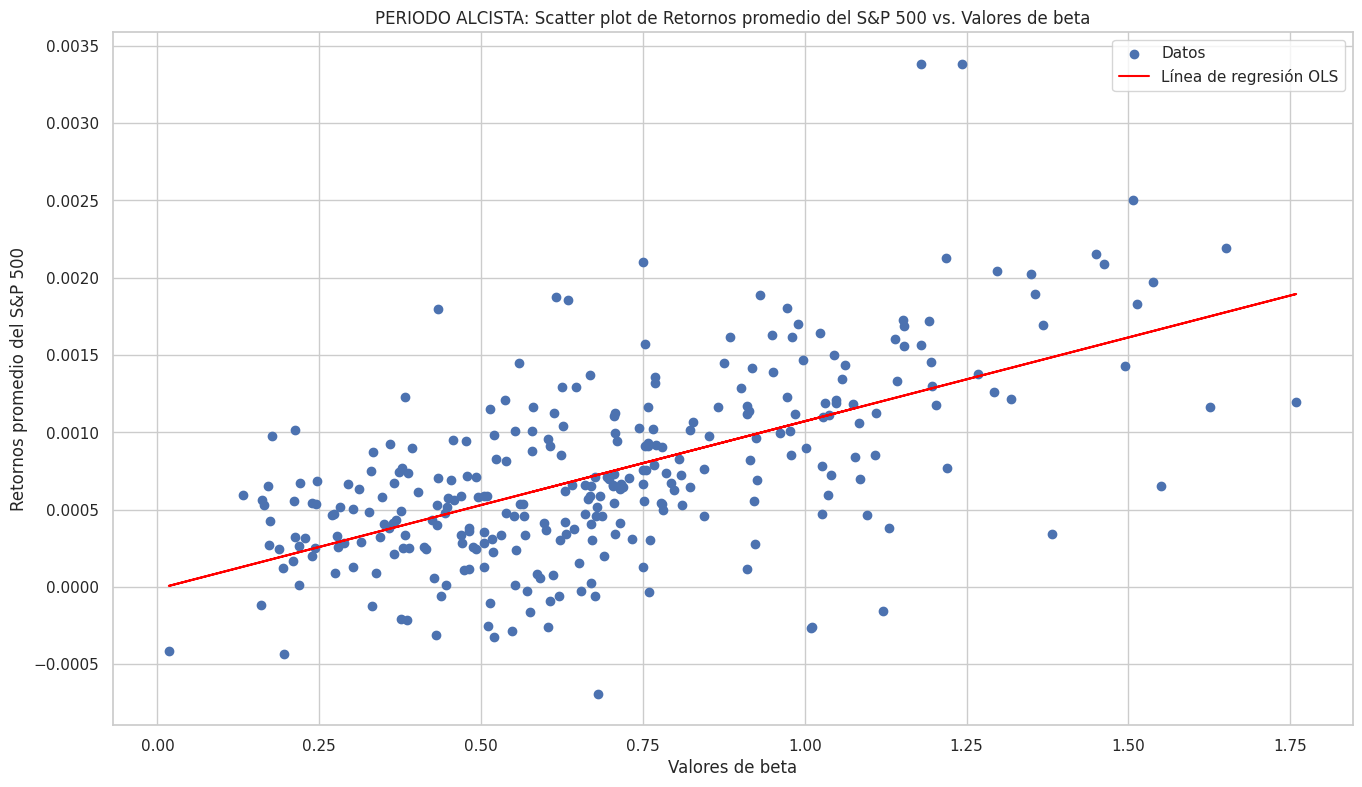

In [72]:
# Obtener los valores ajustados (predicciones del modelo)
valores_ant_ajustados = resultado.predict(betas_ant_con_constante)

# Crear el gráfico de dispersión
plt.scatter(betas_ant, retornos_sp500_ant_promedio, label='Datos')

# Dibujar la línea de regresión
plt.plot(betas_ant, valores_ant_ajustados, color='red', label='Línea de regresión OLS')

# Añadir etiquetas y título
plt.ylabel('Retornos promedio del S&P 500')
plt.xlabel('Valores de beta')
plt.title('PERIODO ALCISTA: Scatter plot de Retornos promedio del S&P 500 vs. Valores de beta')
plt.legend()

# Mostrar el gráfico
plt.show()

#### Periodo Bajista

In [73]:
df_baj_resul, df_baj_summ = calc_regresion(retornos_indice_baj, retornos_baj)

In [74]:
# Obtener los valores de los retornos promedio del S&P 500 y los valores de beta
retornos_sp500_baj_promedio = retornos_baj.mean()
betas_baj = df_baj_resul['beta']

In [75]:
betas_baj_con_constante = sm.add_constant(betas_baj)

# Crear el modelo OLS
modelo = sm.OLS(retornos_sp500_baj_promedio, betas_baj_con_constante)

# Ajustar el modelo
resultado = modelo.fit()

# Mostrar un resumen del modelo
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.402
Model:                            OLS   Adj. R-squared:                  0.400
Method:                 Least Squares   F-statistic:                     201.8
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           2.20e-35
Time:                        10:30:48   Log-Likelihood:                 1690.8
No. Observations:                 302   AIC:                            -3378.
Df Residuals:                     300   BIC:                            -3370.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0012      0.000     11.159      0.0

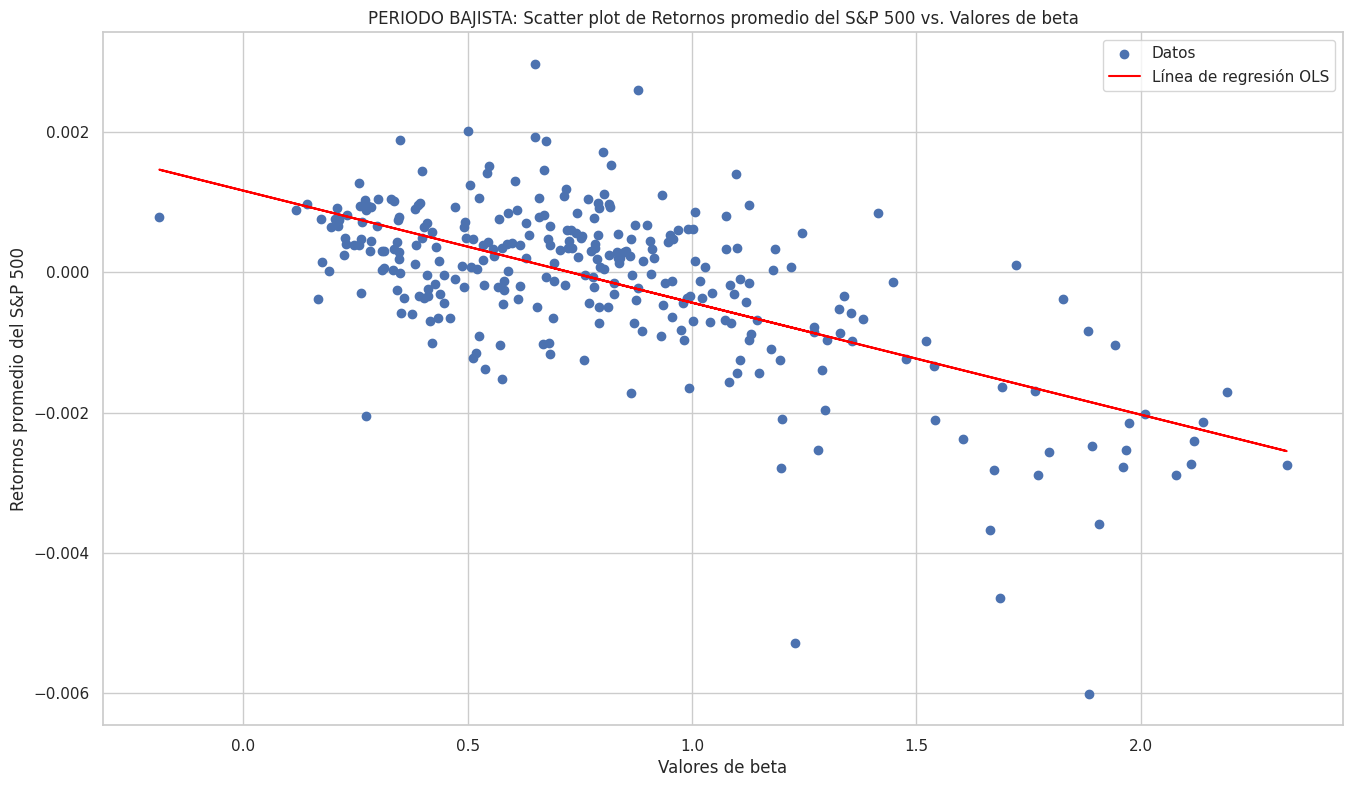

In [76]:
# Obtener los valores ajustados (predicciones del modelo)
valores_baj_ajustados = resultado.predict(betas_baj_con_constante)

# Crear el gráfico de dispersión
plt.scatter(betas_baj, retornos_sp500_baj_promedio, label='Datos')

# Dibujar la línea de regresión
plt.plot(betas_baj, valores_baj_ajustados, color='red', label='Línea de regresión OLS')

# Añadir etiquetas y título
plt.ylabel('Retornos promedio del S&P 500')
plt.xlabel('Valores de beta')
plt.title('PERIODO BAJISTA: Scatter plot de Retornos promedio del S&P 500 vs. Valores de beta')
plt.legend()

# Mostrar el gráfico
plt.show()

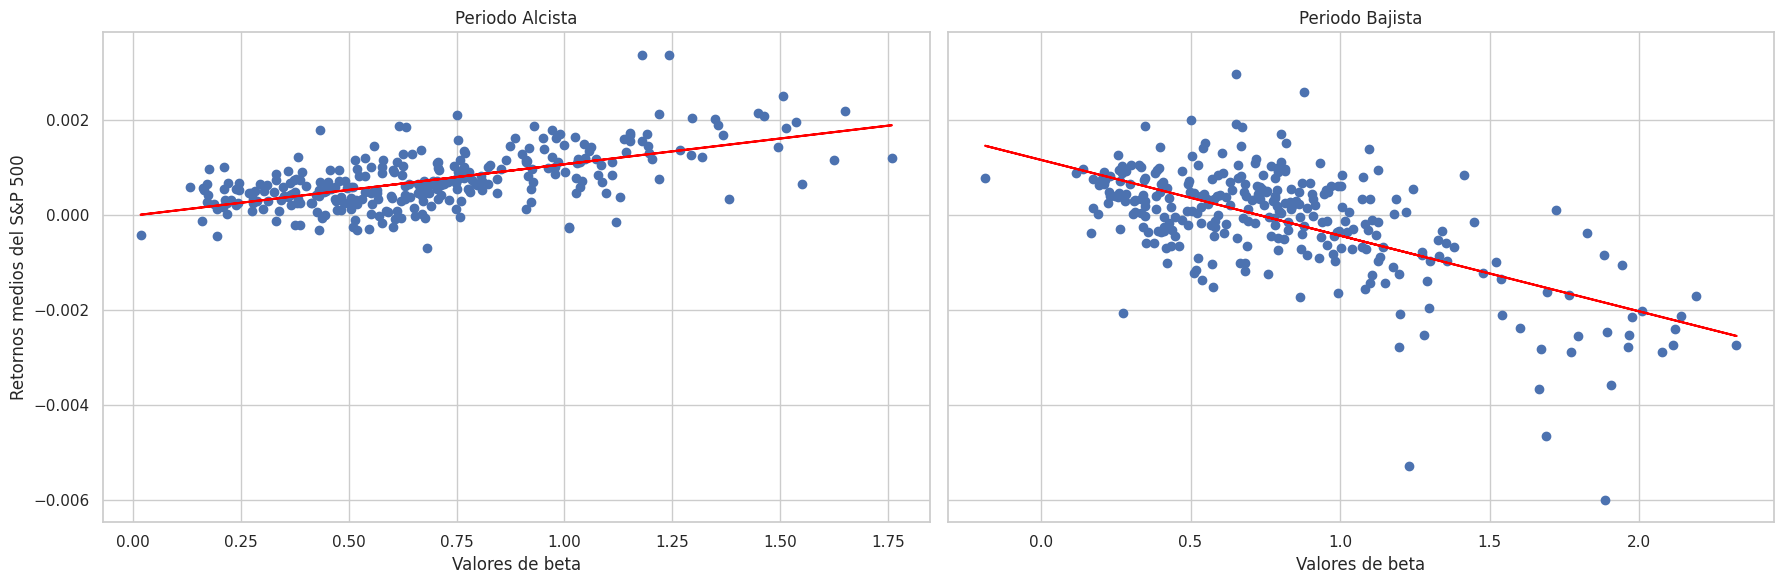

In [77]:


# Creación de la figura y los ejes
fig, axs = plt.subplots(1, 2, figsize=(18, 6), sharey=True)

# Primer gráfico
axs[0].scatter(betas_ant, retornos_sp500_ant_promedio, label='Datos')
axs[0].plot(betas_ant, valores_ant_ajustados, color='red', label='Línea de regresión OLS')
axs[0].set_ylabel('Retornos medios del S&P 500')
axs[0].set_xlabel('Valores de beta')
axs[0].set_title('Periodo Alcista')



# Segundo gráfico
axs[1].scatter(betas_baj, retornos_sp500_baj_promedio, label='Datos')
axs[1].plot(betas_baj, valores_baj_ajustados, color='red', label='Línea de regresión OLS')
#axs[1].set_ylabel('Retornos medios del S&P 500')
axs[1].set_xlabel('Valores de beta')
axs[1].set_title('Periodo Bajista')



# Ajusta automáticamente los parámetros de la subtrama para todo el layout
plt.tight_layout()

# Mostrar la figura completa con ambos gráficos
plt.show()


¿Cambian las $\beta$ del periodo alcista al bajista?

In [78]:
betas_comparar = pd.DataFrame({'betas_ant': betas_ant, 'betas_baj': betas_baj})

betas_comparar

,betas_ant,betas_baj
activo,,
AAPL,1.077741,1.281614
ABT,0.754096,0.448055
ADBE,1.180081,1.764128
ADI,1.349940,2.118004
ADM,0.520085,0.344196
...,...,...
XEL,0.344182,0.519838
XOM,0.538258,0.568671
XRAY,0.347552,0.382232


### Usar periodo alcista para seleccionar activos para periodo bajista

Ahora vamos a investigar si las betas de los activos durante un periodo alcista pueden predecir los retornos en un periodo bajista. Esencialmente, queremos ver si la información de rendimiento en tiempos de mercado alcista sirve para elegir activos durante un mercado bajista.

In [79]:
betas_pred_con_constante = sm.add_constant(betas_ant)

# Crear el modelo OLS
modelo = sm.OLS(retornos_sp500_baj_promedio, betas_pred_con_constante)

# Ajustar el modelo
resultado = modelo.fit()

# Mostrar un resumen del modelo
print(resultado.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.232
Model:                            OLS   Adj. R-squared:                  0.229
Method:                 Least Squares   F-statistic:                     90.45
Date:                Mon, 08 Apr 2024   Prob (F-statistic):           6.45e-19
Time:                        10:30:48   Log-Likelihood:                 1652.9
No. Observations:                 302   AIC:                            -3302.
Df Residuals:                     300   BIC:                            -3294.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0010      0.000      7.673      0.0

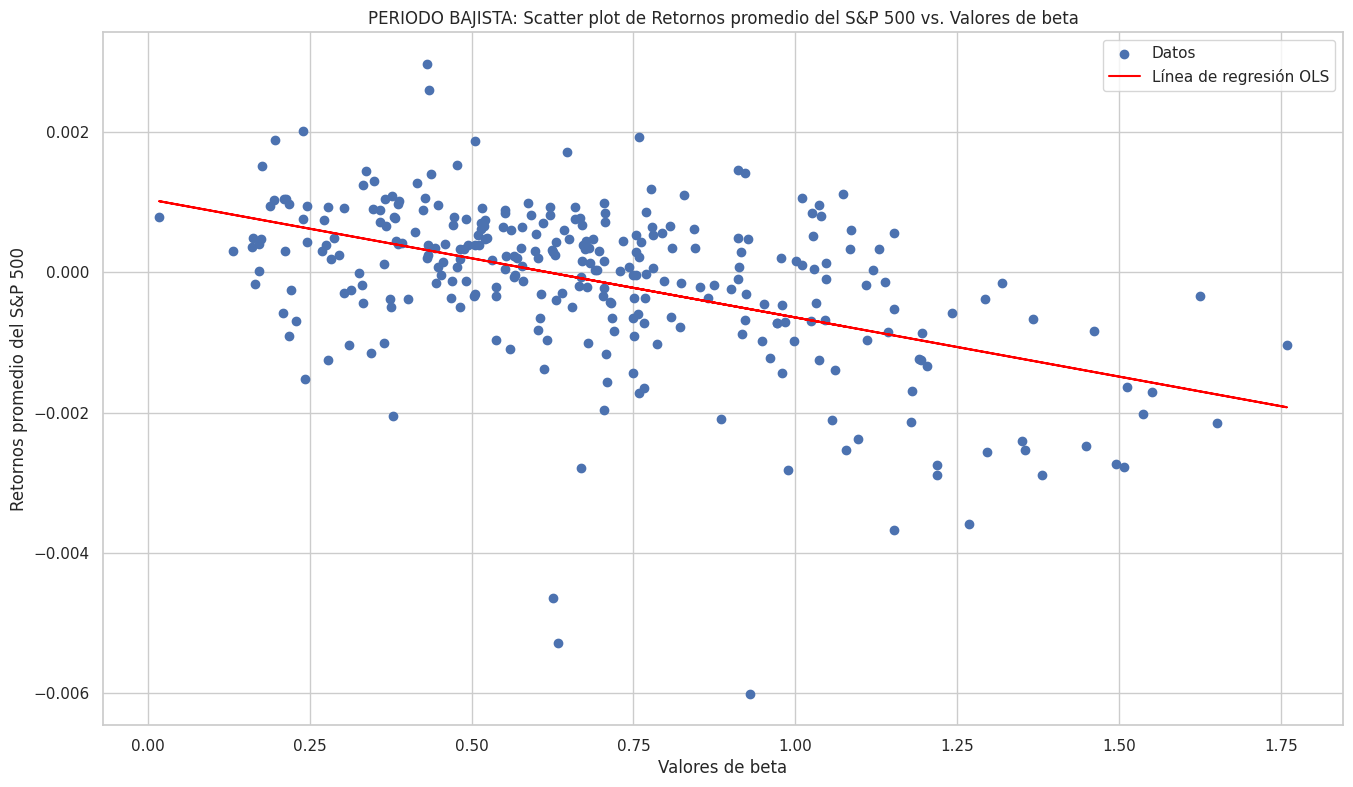

In [80]:
# Obtener los valores ajustados (predicciones del modelo)
valores_pred_ajustados = resultado.predict(betas_pred_con_constante)

# Crear el gráfico de dispersión
plt.scatter(betas_ant, retornos_sp500_baj_promedio, label='Datos')

# Dibujar la línea de regresión
plt.plot(betas_ant, valores_pred_ajustados, color='red', label='Línea de regresión OLS')

# Añadir etiquetas y título
plt.ylabel('Retornos promedio del S&P 500')
plt.xlabel('Valores de beta')
plt.title('PERIODO BAJISTA: Scatter plot de Retornos promedio del S&P 500 vs. Valores de beta')
plt.legend()

# Mostrar el gráfico
plt.show()

### REBALANCEO DE CARTERAS USANDO $\beta$

---
**Gestión Activa de Carteras:**

- **¿Qué es?**: En la gestión activa, un gestor de cartera toma decisiones continuas de compra y venta de activos para superar un índice de referencia o benchmark.
- **Ventajas**:
  - **Potencial de Mayor Rendimiento**: Puede superar al mercado si las decisiones son acertadas.
  - **Adaptabilidad**: Permite ajustarse rápidamente a cambios en el mercado.
  - **Personalización**: Se adapta a objetivos y restricciones específicas del inversor.
- **Inconvenientes**:
  - **Mayores Costos**: Involucra comisiones más altas por las transacciones frecuentes.
  - **Riesgo de Desempeño**: Existe el riesgo de que el gestor no supere al mercado.
  - **Requiere Expertise**: Depende de la habilidad y experiencia del gestor.

**Gestión Pasiva de Carteras:**

- **¿Qué es?**: La gestión pasiva implica replicar un índice de mercado, como el S&P 500, comprando activos en ese índice.
- **Ventajas**:
  - **Menor Costo**: Generalmente, tiene menores comisiones y gastos operativos.
  - **Transparencia y Previsibilidad**: Es más fácil de entender y prever su comportamiento.
  - **Eficiencia a Largo Plazo**: Históricamente, ha mostrado ser eficiente en rendimientos a largo plazo.
- **Inconvenientes**:
  - **Sin Oportunidades de Superar el Mercado**: No busca superar el índice, solo igualarlo.
  - **Menos Flexibilidad**: No se ajusta a cambios específicos del mercado o del inversor.
  - **Riesgo de Mercado**: Está sujeto a la volatilidad total del mercado.

En resumen

- La gestión activa busca superar al mercado (**generar alpha**) con decisiones estratégicas, pero conlleva mayores costos y riesgos
 
- La gestión pasiva busca replicar el rendimiento de un índice con menores costos, pero sin la oportunidad de superar dicho índice. La elección entre ambas depende de los objetivos, el horizonte de tiempo, y la tolerancia al riesgo del inversor.
---


#### Aplicación del modelo de mercado a la gestión de cartera

El exceso de rentabilidad de una cartera viene definido por 

$$\pi_p=\sum_{i=1}^N \pi_i=\sum_{i=1}^N(\alpha_i+\beta_i \pi_m + \bar{\varepsilon}_i)= $$
$$\left[\sum_{i=1}^N w_i\alpha_i\right]+\left[\sum_{i=1}^N w_i\beta_i\pi_M\right] +\left[\sum_{i=1}^N w_i\varepsilon_i\right]=$$
$$\alpha_p+\beta_p \pi_M$$

La beta de una cartera es una **media ponderada** de las betas de los activos que componen la cartera.

El ($\alpha_p$) representa la rentabilidad del fondo que no viene determinada por el riesgo del mercado. Es decir, determina si la gestora del fondo logra batir al mercado. Es una medida del valor que aporta la gestora. Por tanto caben dos posibilidades 

  - $\alpha_p>0$: el fondo bate al mercado.
  - $\alpha_p<0$: el fondo obtiene una rentabilidad por debajo de su riesgo de mercado. 
El valor de $\alpha_p$ depende de la estrategia de selecciónd de activos. La identificación de activos infravalorados puede generar $\alpha_p>0$.

El riesgo de una cartera de acuerdo al modelo de mercado viene determinado por:

$$\sigma^2(\pi_{pt})=\beta_p^2\sigma^2(\pi_{Mt})+\sigma^2(\varepsilon_{pt})$$

Analicemos en primer lugar el efecto de la creación de una cartera sobre el **riesgo específico**:

$$\sigma^2(\varepsilon_{pt})=\sum_{i=1}^N\sum_{j=1}^N w_i w_j \sigma(\varepsilon_{it}\varepsilon_{jt})=$$
$$\sum_{=1}^N w^2_i\sigma^2(\varepsilon_{it})+\sum_{i=1}^N\underset{i\neq j}{\sum_{j=1}^N} w_i w_j \sigma(\varepsilon_{it}\varepsilon_{jt})= $$
$$\sum_{i=1}^N (w_i\sigma(\varepsilon_i))^2$$

Podemos observar que el riesgo específico en el modelo de mercado no se elimina totalmente.

El riesgo sistemático de una cartera viene determinado por:

$$\beta^2=\left[\sum_{i=1}^N w_i\beta_i\right]^2$$


La estrategia de rebalanceo de carteras utilizando las betas implica primero calcular las betas de los activos. Luego, se seleccionan los 10 activos con las betas más altas y los 10 con las más bajas.

- Durante un periodo de mercado alcista, se construye y mantiene una cartera equiponderada con los activos de mayor beta.
 
- Al entrar en un periodo bajista, la estrategia cambia hacia la cartera compuesta por los activos de menor beta.

Seleccionamos los 10 activos con mayores y menores $\beta$

In [81]:
df_ant_beta_ordenado = df_ant_resul.sort_values(by='beta', ascending=False)
tickers_beta_alta = list(df_ant_beta_ordenado.head(10).index)
tickers_beta_baja = list(df_ant_beta_ordenado.iloc[-11:-1,:].index)

Generamos los pesos de la cartera equiponderada

In [82]:
num_activos = 10
pesos = np.ones(num_activos)/num_activos

Calculamos las rentabilidades de la cartera de $\beta$ altas

In [83]:
retornos_cartera_alta =(retornos_ant_baj.loc[:, tickers_beta_alta]@pesos)

Calculamos las rentabilidades de la cartera de $\beta$ bajas

In [84]:
retornos_cartera_baja = (retornos_ant_baj.loc[:, tickers_beta_baja]@pesos)

Calculamos las rentabilidades de la cartera rebalanceada

In [85]:
retornos_bal_alcista = retornos_ant.loc[:, tickers_beta_alta]@pesos
retornos_bal_bajista = retornos_baj.loc[:, tickers_beta_baja]@pesos

retornos_cartera_timing = pd.concat([retornos_bal_alcista, retornos_bal_bajista])

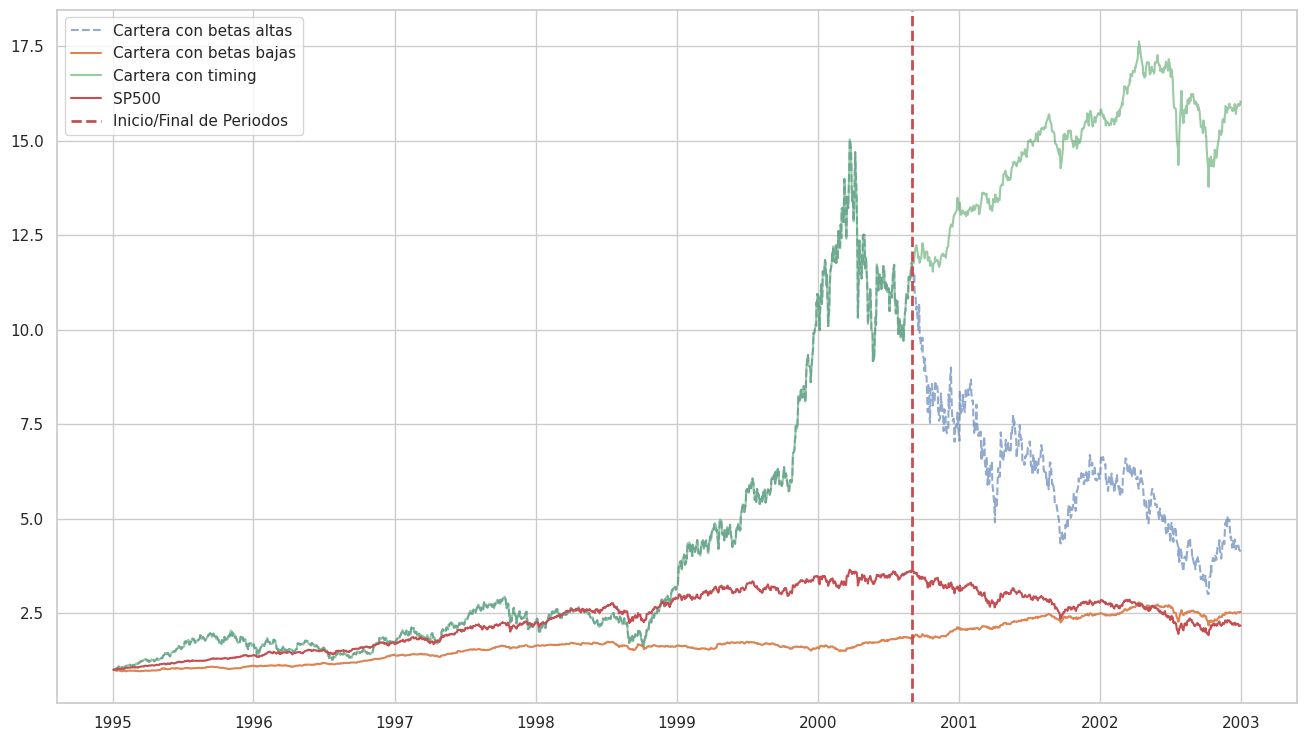

In [86]:
import matplotlib.dates as mdates
plt.plot(np.exp(retornos_cartera_alta.cumsum()), linestyle='--', label='Cartera con betas altas', alpha=0.6)
plt.plot(np.exp(retornos_cartera_baja.cumsum()), label='Cartera con betas bajas')
plt.plot(np.exp(retornos_cartera_timing.cumsum()), label='Cartera con timing', alpha=0.6)
plt.plot(precios_indice_ant_baj/precios_indice_ant_baj.iloc[0], label='SP500')
#plt.axvline('2000-03-01', color='r', linestyle='--', linewidth=2, label='Inicio/Final de Periodos')
# Convertir la fecha de la cadena a un número de fecha que matplotlib puede usar
fecha = mdates.date2num(pd.to_datetime('2000-9-01'))

# Usar este número de fecha para axvline
plt.axvline(fecha, color='r', linestyle='--', linewidth=2, label='Inicio/Final de Periodos')

plt.legend()
plt.show()

### A TENER EN  CUENTA

#### TIMING




Es crucial ser precavido con las estrategias de timing, dado que predecir los cambios exactos en el mercado es extremadamente difícil. Equivocarse incluso por unos pocos días puede alterar significativamente las rentabilidades esperadas.

<center>
    <img src="../imgs/constancia.PNG"  alt="drawing" width="800">


Fuente: Alvaro Gañinanes master MIAX Instituto BME

</center>

#### GENERACIÓN DE ALPHA

¿Qué dicen los datos históricos sobre si los gestores de fondos son capaces de generar alpha?.

Existen numerosos estudios al respecto. Abajo se pueden ver dos ejemplos en los que se confirma que solo un porcentaje muy bajo de gestores son capaces de generar alpha de manera consistente 

Informe de Funspeople [¿Es cierto que la gestión pasiva es mejor que la activa?](https://fundspeople.com/es/es-cierto-que-la-gestion-pasiva-es-mejor-que-la-activa/)

Figura 1: ¿De verdad los gestores superan al mercado?

<img src="../imgs/fondos_superan_indice.PNG"  alt="drawing" width="800"/>

Informe Morningstar's European Active/Passive Barometer Year-End 2022

Figura 2: Porcentaje de fondos que superan al índice

<img src="../imgs/fondos_superan_indice_2.PNG"  alt="drawing" width="700"/>